<h1> Part 2: Introduction </h1>

<div> The goal of this lab is threefold:
    <ul>
        <li> To make minimal amount of changes to our existing code to implement a more complex model. We will implement a multi layered perceptron and use MNIST dataset rather than a set of randomly generated numbers.</li>
        <li> Illustrate the basic principles involved in training of a neural network this time applied to a more complex model. </li>
        <li> Once again illustrate the impact of batch size on the level of noise during the training process.</li>
    </ul>
</div>
<br/>
<div>So let us modify our neural network as discussed in the lecture. We will increase the number of neurons in our simple neural network and increase the number of layers.
    <br/> We will use the MNIST dataset which is composed of 60000 handwritten black and white digits 28 by 28 pixels:
    <br/>We will not be implementing the data loading and batching logic to simplify the exercise. We will use the data downloader and loader that comes together with TensorFlow examples.
</div>

In [1]:
import logging
# Suppress any unnecessary messages to make the output cleaner
logging.getLogger('tensorflow').disabled = True

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
# If the dataset is not present this call will download the dataset from the repository.
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

import tensorflow as tf
import matplotlib.pyplot as plt

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [2]:
# We define some basic parameters of the learning process
learning_rate = 0.1
num_steps = 500
display_step = 100

<div>Since this time our neural network is supposed to be much bigger we need to make more design decisions surrounding its shape. In this case we will create a network with two hidden layers, each with 256 neurons. Since there are 10 possible digits (from 0 to 9) we will have 10 output classes. Since the images are 28 pixels wide and 28 pixels high our input layer needs to be 28*28=784 wide.</div>

In [3]:
# Network Parameters
n_hidden_1 = 256 # 1st layer number of neurons
n_hidden_2 = 256 # 2nd layer number of neurons
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)

<div>Even though our neural network is now much more complex the principles of the model definition remain the same. We define the placeholders for our data and labels and we define the parameters of the neural network.</div>

In [4]:
with tf.device('/device:GPU:0'):
    # Create the placeholders for the data to be used in TensorFlow
    X = tf.placeholder("float", [None, num_input])
    Y = tf.placeholder("float", [None, num_classes])

    # Create our model variables. In previous example we just had two variables w and b. 
    # In this example we replace them with matrices W and B
    W = {
        'h1': tf.Variable(tf.random_normal([num_input, n_hidden_1])),
        'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
        'out': tf.Variable(tf.random_normal([n_hidden_2, num_classes]))
    }
    B = {
        'b1': tf.Variable(tf.random_normal([n_hidden_1])),
        'b2': tf.Variable(tf.random_normal([n_hidden_2])),
        'out': tf.Variable(tf.random_normal([num_classes]))
    }

<div>We then use the above components to assemble the neural network layer after a layer. We conclude by defining the loss function and choosing the optimizer (in this case we will use a much more robust algorithm, that is Adam optimizer).</div>

In [5]:
with tf.device('/device:GPU:0'):
    # Hidden fully connected layer with 256 neurons
    layer_1 = tf.add(tf.matmul(X, W['h1']), B['b1'])
    # Hidden fully connected layer with 256 neurons
    layer_2 = tf.add(tf.matmul(layer_1, W['h2']), B['b2'])
    # Output fully connected layer with a neuron for each class
    out_layer = tf.matmul(layer_2, W['out']) + B['out']

    # And a softmax to give us the actual prediction
    prediction = tf.nn.softmax(out_layer)

    # Define loss and optimizer
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        logits=out_layer, labels=Y))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

<div> We also define some variables that will allow us to track the training progress and overall model performance. </div>

In [6]:
with tf.device('/device:GPU:0'):
    # Evaluate model
    correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

<div>Let's start with a fairly large batch size of 128 to demonstrate the same large vs small batch behavior of the optimizer.</div>

In [7]:
batch_size = 128
loss_array = []

<div> We execute an identical training loop:</div>

In [8]:
# Start training
with tf.Session() as sess:

    # We initialize the necessary variables.
    sess.run(tf.global_variables_initializer())

    for step in range(1, num_steps+1):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={X: batch_x, Y: batch_y})
        # Calculate batch loss and accuracy
        loss_val, acc = sess.run([loss, accuracy], feed_dict={X: batch_x,
                                                                 Y: batch_y})
        loss_array.append(loss_val)
        if step % display_step == 0 or step == 1:
            
            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(loss_val) + ", Training Accuracy= " + \
                  "{:.3f}".format(acc))

    print("Training Finished!")

    # Calculate accuracy for MNIST test images
    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={X: mnist.test.images,
                                      Y: mnist.test.labels}))

Step 1, Minibatch Loss= 12467.1602, Training Accuracy= 0.297
Step 100, Minibatch Loss= 209.2661, Training Accuracy= 0.875
Step 200, Minibatch Loss= 164.2743, Training Accuracy= 0.859
Step 300, Minibatch Loss= 117.9381, Training Accuracy= 0.875
Step 400, Minibatch Loss= 26.1655, Training Accuracy= 0.875
Step 500, Minibatch Loss= 36.6974, Training Accuracy= 0.914
Training Finished!
Testing Accuracy: 0.8699


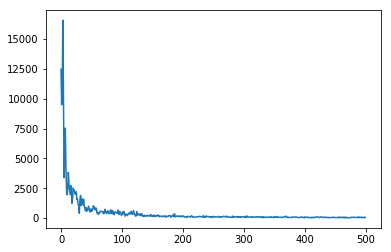

In [9]:
plt.plot(loss_array)
plt.show()

<div> Once again we have obtained the curve demonstrating the evolution of loss in time. Since we have used a large batch size the amount of noise is minimal. Unfortunately, in contrast to the previous exercise, since we now have significantly more than 2 parameters plotting them in 3D space is not possible. </div>

<div>Importantly, in contrast to the previous exercise where our loss function was convex (so had 1 global minimum), overwhelming majority of deep neural networks are not convex. On the contrary they have infinite number of local minima, some of them providing very poor-quality results. Therefore, the optimization problem becomes much more complex. This will be described in more detail in the next lecture.</div>

<br/>
<h3> A side note</h3>
<div>
If understanding of the behavior of your optimization algorithm is important to your problem, there exists an number of ways you can cast this highly multidimensional space into a 3D space. One of the most interesting approaches is described in "Li, H., Xu, Z., Taylor, G., & Goldstein, T. (2017). Visualizing the Loss Landscape of Neural Nets. arXiv preprint arXiv:1712.09913." An example of such a projection can be seen below:
<br/> 
<div>It is important to remember that as an engineer you have direct control of the shape of this function and therefore can directly affect the effectiveness of your optimization algorithm. For example, the below illustrates the impact of skip connections (so a technique used to accelerate the training process of large neural networks) on the shape of the loss function:
<br/>
</div>

<br/>
<h3> Coming back to the exercise</h3>
<div> Let us replicate the above for a substantially smaller batch size</div>

In [10]:
batch_size = 16
loss_array = []

In [11]:
# Start training
with tf.Session() as sess:

    # We initialize the necessary variables.
    sess.run(tf.global_variables_initializer())

    for step in range(1, num_steps+1):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={X: batch_x, Y: batch_y})
        # Calculate batch loss and accuracy
        loss_val, acc = sess.run([loss, accuracy], feed_dict={X: batch_x,
                                                                 Y: batch_y})
        loss_array.append(loss_val)
        if step % display_step == 0 or step == 1:
            
            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(loss_val) + ", Training Accuracy= " + \
                  "{:.3f}".format(acc))

    print("Training Finished!")

    # Calculate accuracy for MNIST test images
    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={X: mnist.test.images,
                                      Y: mnist.test.labels}))

Step 1, Minibatch Loss= 2558.1660, Training Accuracy= 0.750
Step 100, Minibatch Loss= 6399.7461, Training Accuracy= 0.562
Step 200, Minibatch Loss= 1467.2891, Training Accuracy= 0.688
Step 300, Minibatch Loss= 553.6011, Training Accuracy= 0.688
Step 400, Minibatch Loss= 1389.7137, Training Accuracy= 0.750
Step 500, Minibatch Loss= 2182.9182, Training Accuracy= 0.750
Training Finished!
Testing Accuracy: 0.7111


<div> We can clearly see that the level of noise has increased considerably. In contrary to the intuition, since the loss function is not convex, having a level of noise in your gradient estimation is very desirable. In fact, when increasing the number of GPUs participating in training (and as a consequence increasing the batch size) we reduce the amount of noise, the performance of our models tend to degrade (in some cases considerably). This will be one of the key topics of the next lecture.</div>

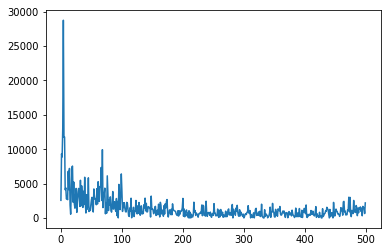

In [12]:
plt.plot(loss_array)
plt.show()

<div> In this exercise we have evolved our linear neuron to a multi layered perceptron and demonstrated that the same approach to training applies. The next exercise will evolve this code further implementing a truly multi GPU variant.</div>

Before you move to the next part of the exercise (in the next notebook) please make sure you free any used GPU resources by restarting the IPYTHON kernel. You can do that either by selecting Kernel->Restart or running the code snipped listed below.

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True) 